# BeeLife: EU Pollinator Hub Assignment

#### Data sources
- Vetcase dataset:  https://app.pollinatorhub.eu/dataset-discovery/VTCSS14.0.0

#### The objective
- standardise the data with the available descriptors (column variables),
- analyse the data,
- produce meaningful results, including some visualisations of the data.

#### The research question
"What is the epidemiological status of Apis mellifera in Austria and Belgium?"

#### Approach
1. Download the dataset raw and its metadata.
2. Read the dataset description for all the tables.
3. Display basic data checks (a few samples, statistical description, missing values).
4. Download the vocabulary data from https://app.pollinatorhub.eu/vocabulary/classes.
5. Check if the disease names are standardized and modify according to the vocabulary (use difflib to detect potential vocabulary matches):
    - "American foulbrood of honey bees" --> "American foulbrood of honey bees (AFB)"
    - "European foulbrood of honey bees" --> "European foulbrood of honey bees (EFB)"
    - "Varroosis of honey bees in the case of imminent or actual death of at least 30% of the colonies in an apiary" --> "Varroosis of honey bees" (and the rest of the description added in the annotations column)
6. Store the modified data in a new file.
7. Explore the status of bees in Austria and Belgium:
    - plot the outbreak durations per disease (KDE, violin and histogram);
    - plot the total outbreak report counts per country;
    - plot the total outbreak report counts per country and per disease;
    - plot the total outbreak report counts per country and per disease;
    - plot the yearly evolution of outbreak reports per country and disease.
8. Display color-encoded overlay on map for:
    - total outbreak report counts per country;
    - total outbreak report counts per NUTS region;
    - latest outbreak report counts per NUTS region.

#### Observations
- Austria reported around 5x more bee-related disease outbreaks between 2006 and 2022.
- The average outbreak duration is 175 days for AFB and 500 days or EFB.
- EFB reports peaked in Belgium in 2020 (17 counts).
- AFB reports peaked in Austria in 2017 (123 counts).
- The number of reports for both types of diseases in Austria and Belgium decreased.


#### Improvement points
- Check reference consistency across tables for missing data or merge mistakes.
- How to handle missing starting dates or ending dates? E.g., the starting date could be created from the year/month of the report; the end date could be infered as average outbreak duration added to the starting date maybe?
- Add pop-up with relevant information on the map (for some reason it does not work even when following the basic tutorial from the folium official website, but it might be a browser issue on my side).
- Create a dynamic time-based map to better visualize the evolution of the outbreaks using TimestampedGeoJson.

### Package imports

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import folium
import geopandas as gpd
from shapely.geometry import shape
from branca.colormap import linear

### Data sources

In [2]:
DATA_FOLDER = '/beelife/data/VTCSS14.0.0'
DATA_FILE_KVG = 'VTCSS14.KVGAB29.0/euph_000014_vetcases_table_kvg.csv'
DATA_FILE_AT = 'VTCSS14.VTCST30.0/euph_000014_vetcases_table_vetcaseat.csv'
DATA_FILE_BE = 'VTCSS14.VTCSB31.0/euph_000014_vetcases_table_vetcasebe.csv'
DATA_FILE_VETCASE = 'VTCSS14.VTCSE33.0/euph_000014_vetcases_table_vetcase.csv'
DATA_FILE_AT_BLURRED = 'VTCSS14.VTCSS32.0/vetcaseat22_blurred.csv'
DATA_FILE_REFERENCES = 'VTCSS14.RFRNC70.0/euph_000014_vetcases_table_references.csv'
VOCABULARY_FILE = '/beelife/data/EUPH Code Book.csv'

### Notebook parameters

In [3]:
VERBOSE = False

### Load dataset

In [4]:
vetcases_df = pd.read_csv(os.path.join(DATA_FOLDER, DATA_FILE_VETCASE))

In [5]:
if VERBOSE:
    print(vetcases_df.head())
    print(vetcases_df.describe())
    print(vetcases_df['disease'].value_counts())
    print(vetcases_df['casenumber'].value_counts())
    print(vetcases_df['annotation'].unique())
    print(vetcases_df.isnull().sum())

### Load vocabulary

In [6]:
vocabulary_df = pd.read_csv(VOCABULARY_FILE)

In [7]:
if VERBOSE:
    print(vocabulary_df.head())
    print(vocabulary_df.describe())
    print(vocabulary_df.value_counts())
    print(vocabulary_df.isnull().sum())

In [8]:
classes = vocabulary_df['Name'].values

### Check dates

In [9]:
vetcases_df['datestart'] = pd.to_datetime(vetcases_df['datestart'])
vetcases_df['dateend'] = pd.to_datetime(vetcases_df['dateend'])
(vetcases_df['dateend'] < vetcases_df['datestart']).sum()

0

In [10]:
# if datestart is missing, add the date of the entry
# Replace NaN (NaT for datetime) with date created from year and month (assuming the day value is 1)
# Replace NaN (NaT for datetime) with date created from year only (assuming the day and month values are 1)
'''
vetcases_df.loc[vetcases_df['datestart'].isna(), 'datestart'] = pd.to_datetime(
    vetcases_df.loc[vetcases_df['datestart'].isna(), ['year', 'month']].assign(day=1)
)
vetcases_df.loc[vetcases_df['datestart'].isna(), 'datestart'] = pd.to_datetime(
    vetcases_df.loc[vetcases_df['datestart'].isna(), ['year']].assign(month=1).assign(day=1)
)

print(vetcases_df.loc[vetcases_df['datestart'].isnull()])
'''

"\nvetcases_df.loc[vetcases_df['datestart'].isna(), 'datestart'] = pd.to_datetime(\n    vetcases_df.loc[vetcases_df['datestart'].isna(), ['year', 'month']].assign(day=1)\n)\nvetcases_df.loc[vetcases_df['datestart'].isna(), 'datestart'] = pd.to_datetime(\n    vetcases_df.loc[vetcases_df['datestart'].isna(), ['year']].assign(month=1).assign(day=1)\n)\n\nprint(vetcases_df.loc[vetcases_df['datestart'].isnull()])\n"

### Check classes 

In [11]:
for class_item in classes:
    if 'Varroosis' in class_item:
        print(class_item)

Varroosis of honey bees


In [12]:
# Find mismatches
columns = ['disease']
classes_not_standardized = {}
for col in columns:
    for item_name in vetcases_df[col].unique():
        if item_name not in classes:
            print(f"Disease --{item_name}-- is not in the standard classes.")
            try:
                classes_not_standardized[col].append(item_name)
            except:
                classes_not_standardized[col] = [item_name]

print(classes_not_standardized)

Disease --American foulbrood of honey bees-- is not in the standard classes.
Disease --Varroosis of honey bees in the case of imminent or actual death of at least 30% of the colonies in an apiary-- is not in the standard classes.
Disease --European foulbrood of honey bees-- is not in the standard classes.
{'disease': ['American foulbrood of honey bees', 'Varroosis of honey bees in the case of imminent or actual death of at least 30% of the colonies in an apiary', 'European foulbrood of honey bees']}


In [13]:
import difflib
for col in classes_not_standardized.keys():
    for class_not_standardized in classes_not_standardized[col]:
        print(class_not_standardized)
        possible_matches = difflib.get_close_matches(class_not_standardized, classes)
        if len(possible_matches) == 0:
            for word in class_not_standardized.split(' '):
                possible_matches.append(difflib.get_close_matches(word, classes))
        print(f"{class_not_standardized} possible matches: \n", possible_matches)    

American foulbrood of honey bees
American foulbrood of honey bees possible matches: 
 ['American foulbrood of honey bees (AFB)', 'European foulbrood of honey bees (EFB)', 'Chalkbrood disease of honey bees']
Varroosis of honey bees in the case of imminent or actual death of at least 30% of the colonies in an apiary
Varroosis of honey bees in the case of imminent or actual death of at least 30% of the colonies in an apiary possible matches: 
 [[], [], ['honey', 'Honey', 'honeydew'], ['beeswax', 'beehouse', 'Abies'], ['wind', 'Wine', 'Kina'], ['other', 'Other', 'Vetches'], ['case', 'increase', 'crane'], [], ['Pimento', 'Commitment'], ['hour', 'Coir'], ['katal', 'pascal', 'data'], ['death', 'eats', 'date'], [], ['watt', 'eats', 'date'], ['plastic', 'eats', 'Peas'], [], [], ['other', 'Other', 'Vetches'], ['colony'], ['wind', 'Wine', 'Kina'], ['anus', 'Rand', 'Oman'], ['apiary', 'apiary ID', 'apiary name']]
European foulbrood of honey bees
European foulbrood of honey bees possible matches: 


### Manual standardization

In [14]:
row_index = vetcases_df['disease'] == 'American foulbrood of honey bees'
vetcases_df.loc[row_index, 'disease'] = 'American foulbrood of honey bees (AFB)'

In [15]:
row_index = vetcases_df['disease'] == 'European foulbrood of honey bees'
vetcases_df.loc[row_index, 'disease'] = 'European foulbrood of honey bees (EFB)'

In [16]:
row_index = vetcases_df['disease'] == 'Varroosis of honey bees in the case of imminent or actual death of at least 30% of the colonies in an apiary'
vetcases_df.loc[row_index, 'annotation'] = "in the case of imminent or actual death of at least 30% of the colonies in an apiary"
vetcases_df.loc[row_index, 'disease'] = 'Varroosis of honey bees'

row_index = vetcases_df['disease'] == 'Varroosis of honey bees'
vetcases_df.loc[row_index, 'annotation'].apply(lambda x: x + " new")

463    in the case of imminent or actual death of at ...
493    in the case of imminent or actual death of at ...
Name: annotation, dtype: object

In [17]:
# Verify
print(vetcases_df['disease'].value_counts())
print(vetcases_df['casenumber'].value_counts())
print(vetcases_df['annotation'].unique())

disease
American foulbrood of honey bees (AFB)    560
European foulbrood of honey bees (EFB)     35
Varroosis of honey bees                     2
Name: count, dtype: int64
casenumber
TKH-2014-000443    1
TKH-2018-000075    1
TKH-2018-000065    1
TKH-2018-000064    1
TKH-2018-000061    1
                  ..
TKH-2016-000164    1
TKH-2016-000163    1
TKH-2016-000162    1
TKH-2016-000161    1
TKH-2020-000052    1
Name: count, Length: 460, dtype: int64
[nan
 'in the case of imminent or actual death of at least 30% of the colonies in an apiary']


### Export standardized data

In [18]:
vetcases_df.to_csv(os.path.join(DATA_FOLDER, ".".join(DATA_FILE_VETCASE.split('.')[:-1]) + '_edit.csv'))

### Explore the status of bees in Belgium and Austria

In [19]:
vetcases_df['duration'] = (vetcases_df['dateend'] - vetcases_df['datestart']).dt.days

In [20]:
(vetcases_df['duration'] < 0).sum()

0

In [21]:
# Average outbreak duration per disease
vetcases_group_by_disease = vetcases_df.groupby(['disease']).agg({"duration":"mean"})
print(vetcases_group_by_disease)

                                          duration
disease                                           
American foulbrood of honey bees (AFB)  175.519084
European foulbrood of honey bees (EFB)  502.968750
Varroosis of honey bees                        NaN


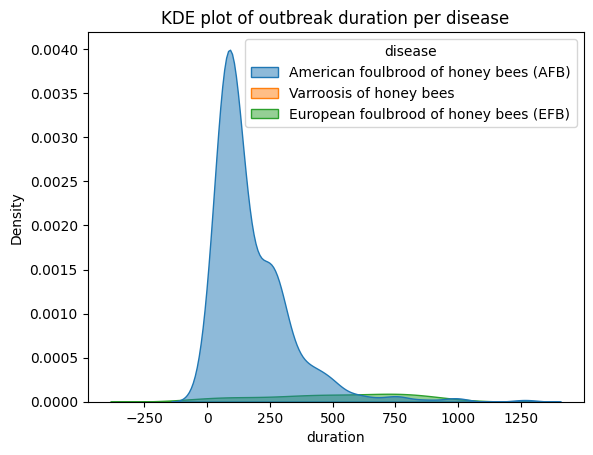

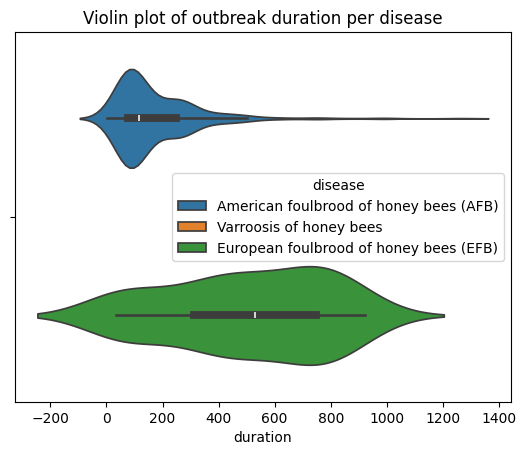

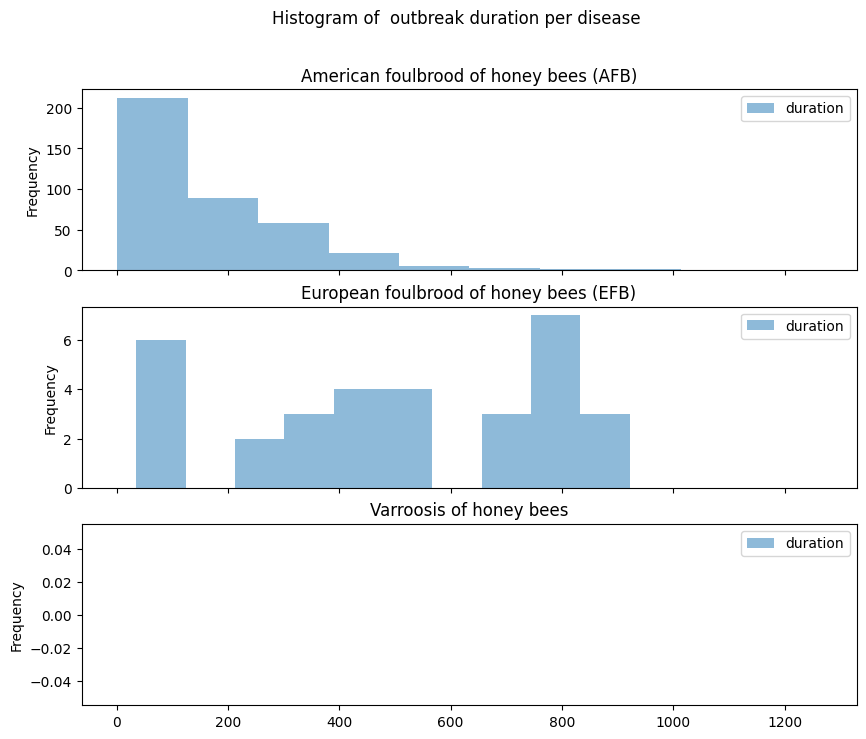

In [22]:
# Outbreak durations per disease
sns.kdeplot(data=vetcases_df, x='duration', hue = 'disease', alpha=0.5, fill=True)
plt.title(f"KDE plot of outbreak duration per disease")
plt.show()

sns.violinplot(data=vetcases_df, x = 'duration', hue = 'disease')
plt.title(f"Violin plot of outbreak duration per disease")
plt.show()

ax = vetcases_df.plot.hist(column='duration', by='disease', alpha=0.5, sharex=True, figsize=(10, 8), title="Histogram of  outbreak duration per disease")
plt.show()

  country  counts
0     AUT     513
1     BEL      84


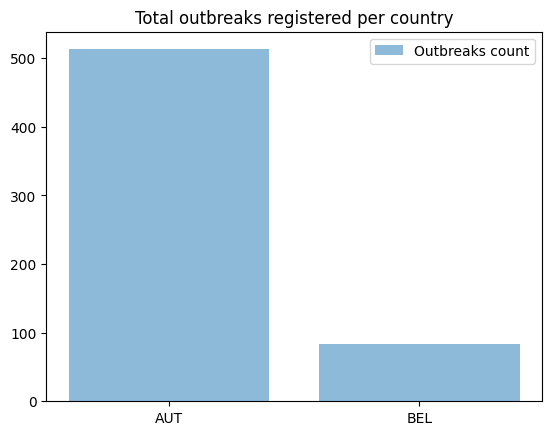

In [23]:
# Outbreaks / country
vetcases_group_by_country_count = vetcases_df.groupby(['country']).size().reset_index(name='counts')
print(vetcases_group_by_country_count)
plt.bar(vetcases_group_by_country_count['country'], vetcases_group_by_country_count['counts'], label='Outbreaks count', alpha=0.5)
plt.title("Total outbreaks registered per country")
plt.legend()
plt.show()

                                  disease country  counts
0  American foulbrood of honey bees (AFB)     AUT     511
1  American foulbrood of honey bees (AFB)     BEL      49
2  European foulbrood of honey bees (EFB)     BEL      35
3                 Varroosis of honey bees     AUT       2


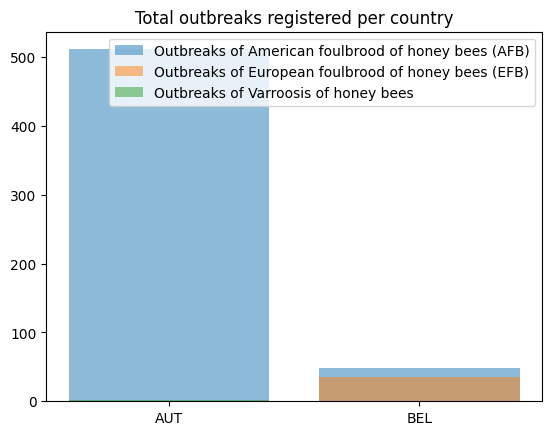

In [24]:
# Outbreaks / country / disease
vetcases_group_by_country_disease_count = vetcases_df.groupby(['disease', 'country']).size().reset_index(name='counts')
print(vetcases_group_by_country_disease_count)
for disease in vetcases_group_by_country_disease_count['disease'].unique():
    vetcases_group_by_country_disease_count_filtered_by_disease = vetcases_group_by_country_disease_count[
                                                                        vetcases_group_by_country_disease_count['disease']==disease]
    plt.bar(vetcases_group_by_country_disease_count_filtered_by_disease['country'], 
            vetcases_group_by_country_disease_count_filtered_by_disease['counts'], 
            label=f'Outbreaks of {disease}', 
            alpha=0.5)
plt.title("Total outbreaks registered per country")
plt.legend()
plt.show()

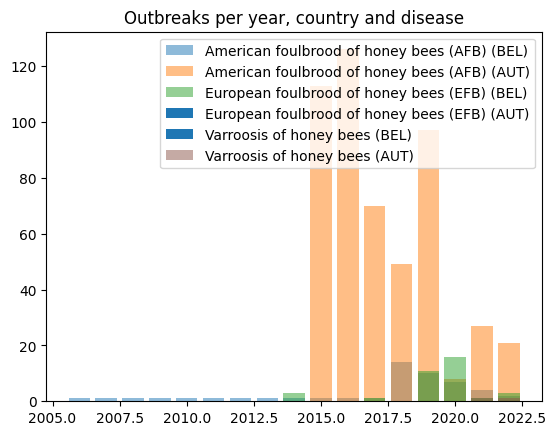

In [25]:
# Outbreaks / year / country / disease
vetcases_group_by_year_country_disease_count = vetcases_df.groupby(['year','country', 'disease']).size().reset_index(name='counts')
for disease in vetcases_group_by_year_country_disease_count['disease'].unique():
    for country in vetcases_group_by_year_country_disease_count['country'].unique():
        vetcases_per_country = vetcases_group_by_year_country_disease_count[vetcases_group_by_year_country_disease_count['country']==country].copy()
        vetcases_per_country_disease = vetcases_per_country[vetcases_per_country['disease']==disease]
        plt.bar(vetcases_per_country_disease['year'], vetcases_per_country_disease['counts'], label=f"{disease} ({country})", alpha=0.5)
plt.title(f"Outbreaks per year, country and disease")
plt.legend()
plt.show()

In [26]:
# Outbreaks duration / year / country
vetcases_df['nuts'].value_counts()
vetcases_df_small_regions = vetcases_df[vetcases_df['nuts'].str.len() > 2]
vetcases_df_small_regions_by_region_outbreak_count = vetcases_df_small_regions.groupby(['year','nuts']).size().reset_index(name='counts')
vetcases_df_small_regions_by_region_outbreak_count

,year,nuts,counts
0,2014,BE221,1
1,2014,BE323,1
2,2014,BE32A,1
3,2015,AT12,44
4,2015,AT21,2
...,...,...,...
85,2022,AT32,1
86,2022,AT33,1
87,2022,BE321,1
88,2022,BE322,2


### Display map of total outbreak reports per country

In [27]:
# Define data
vetcases_group_by_country_count = vetcases_df.groupby(['country']).size().reset_index(name='counts')

colormap = linear.YlOrRd_04.scale(0, vetcases_group_by_country_count['counts'].max())

# To be beautified using: https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html

# Initialize the map (e.g., centered in Europe)
m = folium.Map(location=[50, 10], zoom_start=6)

# Load the shapefile
shapefile_path = "/beelife/data/NUTS_RG_20M_2021_3035.shp" 

gdf = gpd.read_file(shapefile_path)

# Filter the GeoDataFrame by NUTS code

region_ids = vetcases_df['country'].unique()

for i, nuts_code in enumerate(region_ids):
    if nuts_code == 'BEL':
        region = gdf[gdf['NUTS_ID'] == 'BE'].copy()
    elif nuts_code == 'AUT':
        region = gdf[gdf['NUTS_ID'] == 'AT'].copy()
    else:
        continue
    '''
    # Get the centroid of the region for map centering 
    centroid = region.geometry.centroid.iloc[0] 
    latitude = centroid.y 
    longitude = centroid.x 
    '''
    if len(region.index) == 0:
        continue
        
    region["outbreaks"] = vetcases_group_by_country_count[vetcases_group_by_country_count['country'] == nuts_code]['counts'].values[0]
    # Add the region to the map (Convert the geometry into GeoJSON and add it as a feature)
    folium.GeoJson( region, style_function=lambda x: { 'fillColor': colormap(x["properties"]["outbreaks"]), # Highlight color 
                                                  'color': 'black', # Border color 
                                                  'weight': 2, # Border width 
                                                  'fillOpacity': 0.5, # Fill opacity 
                                                 }).add_to(m) 

# Add colormap to the map
colormap.caption = "Outbreak count per country"
colormap.add_to(m)

# Display the map in the notebook
m

In [28]:
# Save the map 
m.save("highlighted_country_map.html") # Save the map to an HTML file

### Display map of outbreak reports per region

In [29]:
# Define data
vetcases_group_by_region_count = vetcases_df.groupby(['nuts']).size().reset_index(name='counts')

colormap = linear.YlOrRd_04.scale(0, vetcases_group_by_region_count['counts'].max())

# To be beautified using: https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html

# Initialize the map (e.g., centered in Europe)
m = folium.Map(location=[50, 10], zoom_start=6)

# Load the shapefile
shapefile_path = "/beelife/data/NUTS_RG_20M_2024_3035.shp" 

gdf = gpd.read_file(shapefile_path)

# Filter the GeoDataFrame by NUTS code

region_ids = vetcases_df['nuts'].unique()

for i, nuts_code in enumerate(region_ids):
    if len(nuts_code) < 3: # Only consider region codes, not country codes
        continue

    region = gdf[gdf['NUTS_ID'] == nuts_code].copy()
    '''
    # Get the centroid of the region for map centering 
    centroid = region.geometry.centroid.iloc[0] 
    latitude = centroid.y 
    longitude = centroid.x 
    '''
    if len(region.index) == 0:
        continue
        
    region["outbreaks"] = vetcases_group_by_region_count[vetcases_group_by_region_count['nuts'] == nuts_code]['counts'].values[0]
    # Add the region to the map (Convert the geometry into GeoJSON and add it as a feature)
    folium.GeoJson( region, style_function=lambda x: { 'fillColor': colormap(x["properties"]["outbreaks"]), # Highlight color 
                                                  'color': 'black', # Border color 
                                                  'weight': 2, # Border width 
                                                  'fillOpacity': 0.5, # Fill opacity 
                                                 }).add_to(m) 

# Add colormap to the map
colormap.caption = "Outbreak count per region"
colormap.add_to(m)

# Display the map in the notebook
m

In [30]:
# Save the map 
m.save("highlighted_region_map.html") # Save the map to an HTML file

### Latest outbreak report count per region

In [31]:
# Define data
vetcases_group_by_year_region_count = vetcases_df.groupby(['nuts']).agg({'year':['max', 'count']}).reset_index()
vetcases_group_by_year_region_count.columns = ['nuts', 'year', 'count']

# Define colormap
colormap = linear.YlOrRd_04.scale(0, vetcases_group_by_year_region_count['count'].max())

# To be beautified using: https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html

# Initialize the map (e.g., centered in Europe)
m = folium.Map(location=[50, 10], zoom_start=6)

# Load the shapefile
shapefile_path = "/beelife/data/NUTS_RG_20M_2024_3035.shp" 

gdf = gpd.read_file(shapefile_path)

# Filter the GeoDataFrame by NUTS code

region_ids = vetcases_df['nuts'].unique()

for i, nuts_code in enumerate(region_ids):
    if len(nuts_code) < 3: # Only consider region codes, not country codes
        continue

    region = gdf[gdf['NUTS_ID'] == nuts_code].copy()
    '''
    # Get the centroid of the region for map centering 
    centroid = region.geometry.centroid.iloc[0] 
    latitude = centroid.y 
    longitude = centroid.x 
    '''
    if len(region.index) == 0:
        continue
    region["year"] = vetcases_group_by_year_region_count[vetcases_group_by_year_region_count['nuts'] == nuts_code]['year'].values[0]
    region["outbreaks"] = vetcases_group_by_year_region_count[vetcases_group_by_year_region_count['nuts'] == nuts_code]['count'].values[0]

    # Add the region to the map (Convert the geometry into GeoJSON and add it as a feature)
    folium.GeoJson(region, style_function=lambda x: { 'fillColor': colormap(x["properties"]["outbreaks"]), # Highlight color 
                                                  'color': 'black', # Border color 
                                                  'weight': 2, # Border width 
                                                  'fillOpacity': 0.5, # Fill opacity 
                                                 }).add_to(m) 

# Add colormap to the map
colormap.caption = "Outbreak count per region"
colormap.add_to(m)

# Display the map in the notebook
m

In [32]:
# Save the map 
m.save("highlighted_latest_region_map.html") # Save the map to an HTML file